# Part 1 - Visualizing the Data

Before diving straight into building and training the GAN architecture, it helps to first make sure we can properly load and visualize the data.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.optim as optim
import numpy as np
from src.config import PROCESSED_DATA_DIR
import matplotlib.pyplot as plt

from src.config import batch_size, image_size, nc, nz, ngf, ndf, num_epochs, lr, beta1, ngpu

2025-04-16 17:05:10.077 | INFO     | src.config:<module>:10 - PROJ_ROOT path is: C:\Git\ai-art-generator


In [2]:
dataset = datasets.ImageFolder(
    root=PROCESSED_DATA_DIR,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])
)

In [3]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

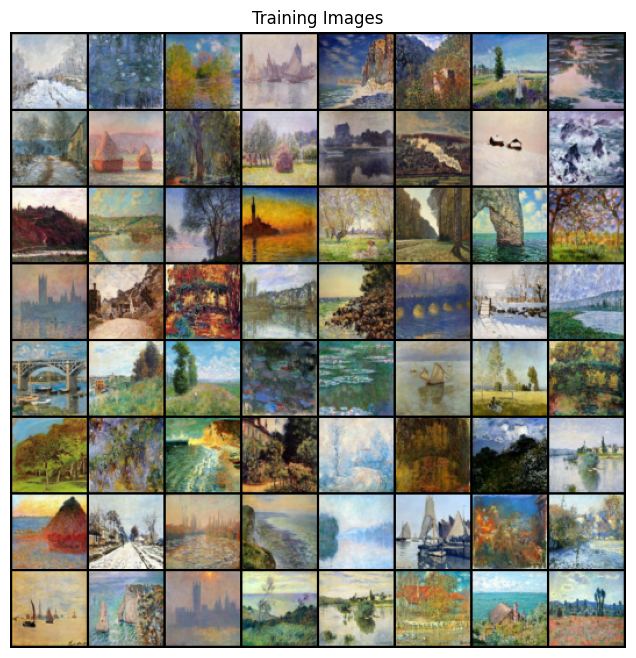

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Part 2 - Implementation

Now we can begin implementing the Generator and Discriminator architectures. First we need to create a function to properly initialize the weights.

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

The generator is designed to map the latent space vector (z) to an image-space. We can create an RGB image from an input vector though a series of convolutional transpose layers.

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [8]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


The discriminator is designed to classify images as either fake or real. Since this is a basic binary image classification task, the discriminator will just be a usual CNN. Note if we use Wasserstein Loss we remove the sigmoid layer at the end.

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


# Part 3 - Training

After implementing the Generator and Discriminator architectures, we proceed to training.

In [11]:
# criterion = nn.BCELoss()
# fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Batch of latent vectors
# 
# real_label = 1.
# fake_label = 0.
# 
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

The below block is for training with BCE Loss (Commented out).

In [12]:
# # Training Loop
# 
# # Lists to keep track of progress
# img_list = []
# G_losses = []
# D_losses = []
# iters = 0
# 
# print("Starting Training Loop...")
# # For each epoch
# for epoch in range(num_epochs):
#     # For each batch in the dataloader
#     for i, data in enumerate(dataloader, 0):
# 
#         ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ###########################
#         ## Train with all-real batch
#         netD.zero_grad()
#         # Format batch
#         real_cpu = data[0].to(device) # Gets real images from the dataloader and moves them to the correct device
#         b_size = real_cpu.size(0) # Gets batch size
#         label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # Create a tensor of 'real' labels
#         # Forward pass real batch through D
#         output = netD(real_cpu).view(-1) # Passes real images through discriminator reshaping the output to a flat vector
#         # Calculate loss on all-real batch
#         errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         errD_real.backward()
#         D_x = output.mean().item()
# 
#         ## Train with all-fake batch
#         # Generate batch of latent vectors
#         noise = torch.randn(b_size, nz, 1, 1, device=device)
#         # Generate fake image batch with G
#         fake = netG(noise)
#         label.fill_(fake_label)
#         # Classify all fake batch with D
#         output = netD(fake.detach()).view(-1)
#         # Calculate D's loss on the all-fake batch
#         errD_fake = criterion(output, label)
#         # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         # Compute error of D as sum over the fake and the real batches
#         errD = errD_real + errD_fake
#         # Update D
#         optimizerD.step()
# 
#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         output = netD(fake).view(-1)
#         # Calculate G's loss based on this output
#         errG = criterion(output, label)
#         # Calculate gradients for G
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         # Update G
#         optimizerG.step()
# 
#         # Output training stats
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
# 
#         # Save Losses for plotting later
#         G_losses.append(errG.item())
#         D_losses.append(errD.item())
# 
#         # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
# 
#         iters += 1

The below block is for training with Wasserstein distance

In [13]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Batch of latent vectors

real_label = 1.
fake_label = 0.

optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
clip_value = 0.01 # For weight clipping
n_critic = 5 # Number of discriminator updates per generator update

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network (critic) n_critic times
        ###########################
        for _ in range(n_critic):
            optimizerD.zero_grad()
            
            # Format batch
            real_images = data[0].to(device)
            batch_size = real_images.size(0)
            
            # Forward pass real batch through D
            real_validity = netD(real_images).view(-1)
            
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            fake_validity = netD(fake_images.detach()).view(-1)
            
            errD= -torch.mean(real_validity) + torch.mean(fake_validity)
            
            errD.backward()
            optimizerD.step()
            
            for p in netD.parameters():
                p.data.clamp_(-clip_value, clip_value)
            
        # Track statistics for logging
        D_x = real_validity.mean().item()  # Average critic score on real data
        D_G_z1 = fake_validity.mean().item()  # Average critic score on fake data
        
        ############################
        # (2) Update G network once per n_critic iterations
        ###########################

        optimizerG.zero_grad()
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        fake_validity = netD(fake_images)
        errG = -torch.mean(fake_validity)
        errG.backward()
        optimizerG.step()
        
        # Track more statistics
        D_G_z2 = fake_validity.mean().item()  # New average critic score on fake data after G update

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/4000][0/3]	Loss_D: -0.1764	Loss_G: 0.1407	D(x): 0.0608	D(G(z)): -0.1156 / -0.1407
[1/4000][0/3]	Loss_D: -0.3782	Loss_G: 0.2759	D(x): 0.1237	D(G(z)): -0.2545 / -0.2759
[2/4000][0/3]	Loss_D: -0.5268	Loss_G: 0.3546	D(x): 0.1974	D(G(z)): -0.3294 / -0.3546
[3/4000][0/3]	Loss_D: -0.4125	Loss_G: 0.4061	D(x): 0.2625	D(G(z)): -0.1500 / -0.4061
[4/4000][0/3]	Loss_D: -0.1704	Loss_G: 0.2803	D(x): 0.2170	D(G(z)): 0.0466 / -0.2803
[5/4000][0/3]	Loss_D: -0.4022	Loss_G: -0.2192	D(x): 0.0448	D(G(z)): -0.3574 / 0.2192
[6/4000][0/3]	Loss_D: -0.5790	Loss_G: 0.1453	D(x): 0.2012	D(G(z)): -0.3778 / -0.1453
[7/4000][0/3]	Loss_D: -0.3870	Loss_G: 0.3877	D(x): 0.3930	D(G(z)): 0.0059 / -0.3877
[8/4000][0/3]	Loss_D: -0.7425	Loss_G: 0.4015	D(x): 0.2928	D(G(z)): -0.4497 / -0.4015
[9/4000][0/3]	Loss_D: -1.0229	Loss_G: 0.5206	D(x): 0.4915	D(G(z)): -0.5314 / -0.5206
[10/4000][0/3]	Loss_D: -1.1248	Loss_G: 0.5767	D(x): 0.5511	D(G(z)): -0.5737 / -0.5767
[11/4000][0/3]	Loss_D: -1.1644	Loss_G: 0

# Part 4 - Results

After training is complete, we can see the results of our model by plotting the loss and comparing real to fake images. Some iteration and experimenting with hyperparameters may be necessary.

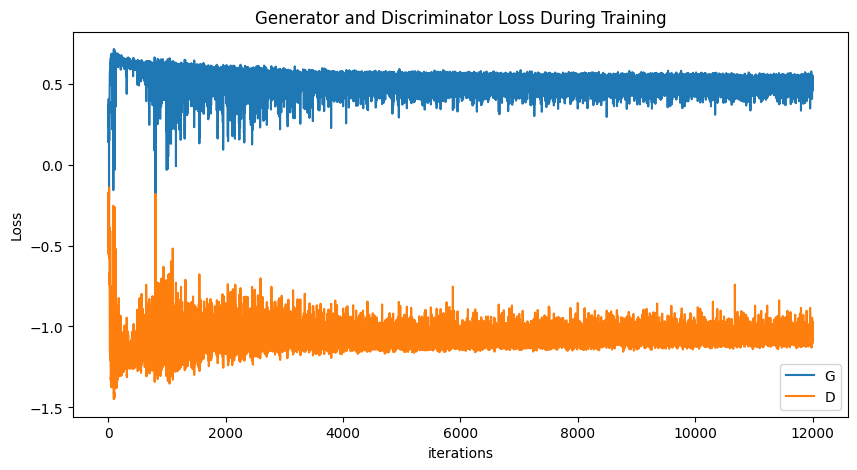

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

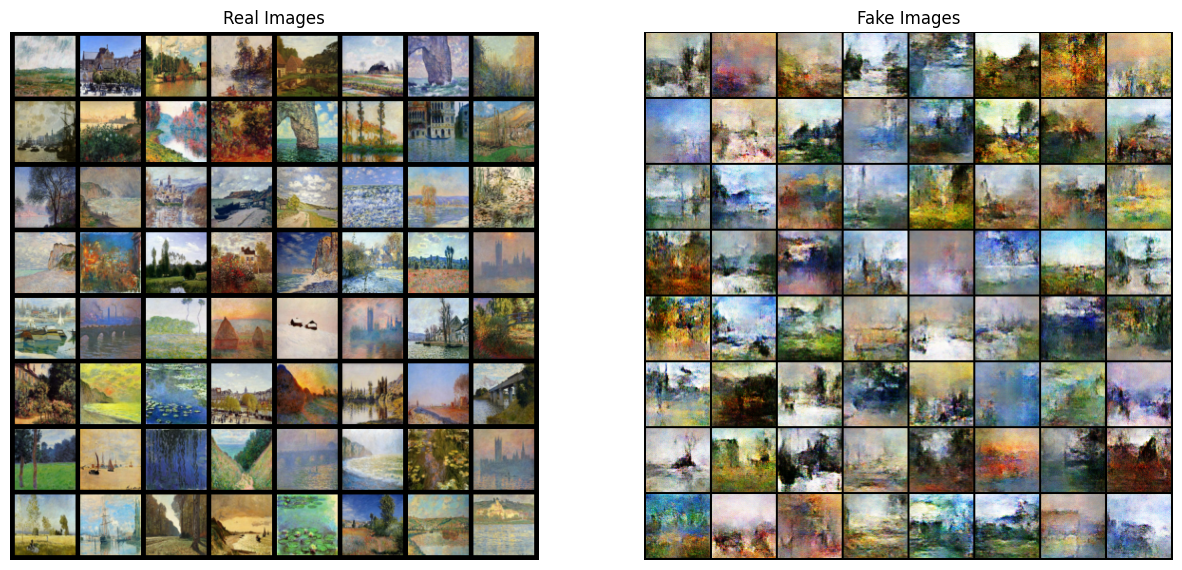

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Part 5 - Saving the model

If we are happy with the generator's performance, we can save the model.

In [17]:
torch.save(netG.state_dict(), 'generator.pth')